Multi class classification problem

Fifa 19 Dataset is used for the problem. Depending on the position, we need to predict the Player's role in the field.

In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

In [274]:
df = pd.read_csv('https://query.data.world/s/2kkwvzhoqaiywsn65wzuxmelrgduvh?dws=00000')
df.describe()
df.isna().sum()
df.head()
df.shape

(18207, 89)

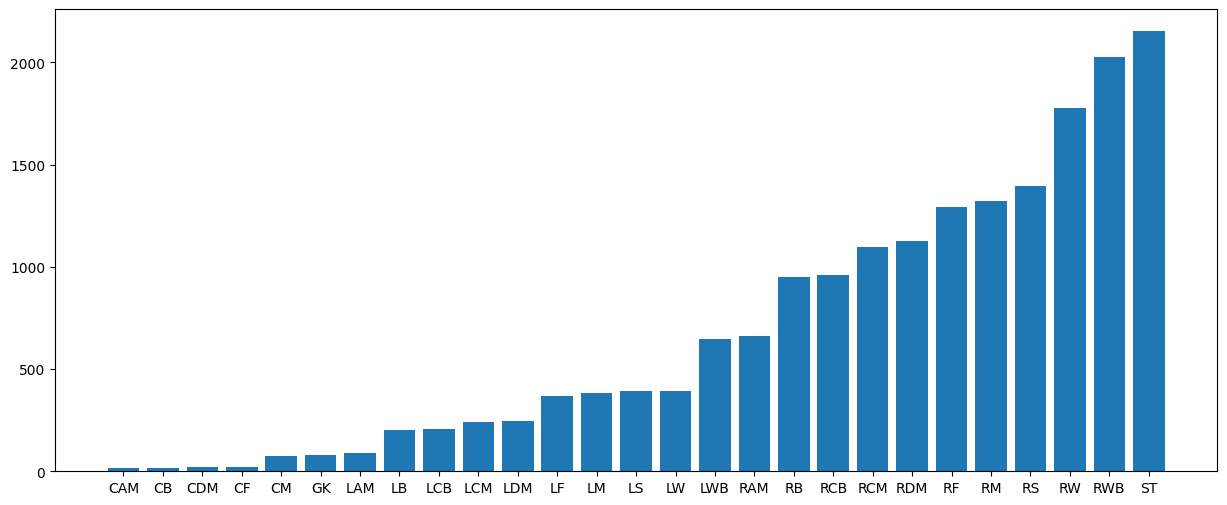

In [275]:
plt.figure(figsize=(15,6))
plt.bar(df.groupby('Position').ID.count().index,sorted(df.groupby('Position').ID.count().values))
plt.show()

In [276]:
# categorize positions

forward_player = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder_player = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender_player = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]

df.loc[df['Position'] == 'GK'] = 0
df.loc[df['Position'].isin(defender_player),'Position'] = 1
df.loc[df['Position'].isin(midfielder_player),'Position'] = 2
df.loc[df['Position'].isin(forward_player),'Position'] = 3

df.head()
df.Position.value_counts(normalize=True)


2    0.376812
1    0.323249
3    0.188351
0    0.111589
Name: Position, dtype: float64

In [278]:
# filtering only required columns for model & remove NaN
df = df[["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']]
df.isna().sum()
df.dropna(inplace=True)
df.head()
df.shape

(18147, 34)

In [279]:
# train test split

x = df.loc[:,df.columns != 'Position']
y = df['Position'].astype('int')
n_classes = list(set(y))
y_bin = label_binarize(y, classes = n_classes)

x_train, x_test, y_train, y_test = train_test_split(x,y_bin,test_size=0.2, random_state=42)

In [280]:
# scaling

scaler = StandardScaler().fit(x_train)
x_train_sca = scaler.transform(x_train)
x_test_sca = scaler.transform(x_test)

In [281]:
# logistic model - OVR

model = OneVsRestClassifier(LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter=500)).fit(x_train_sca,y_train)
predict_train = model.predict(x_train_sca)
predict_test = model.predict(x_test_sca)

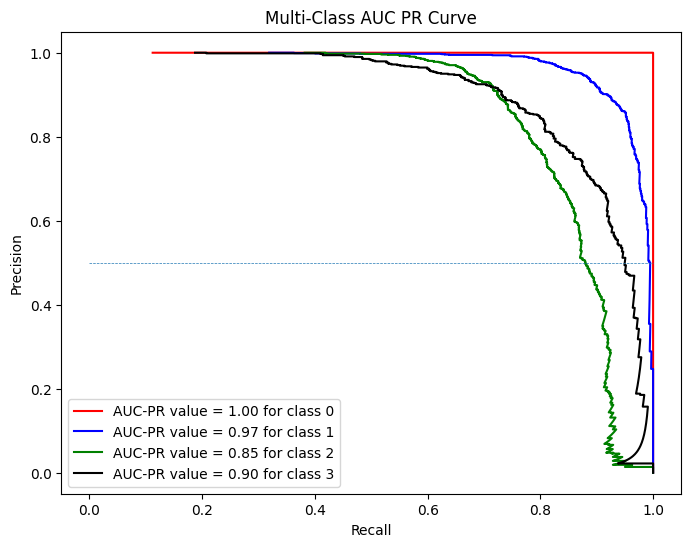

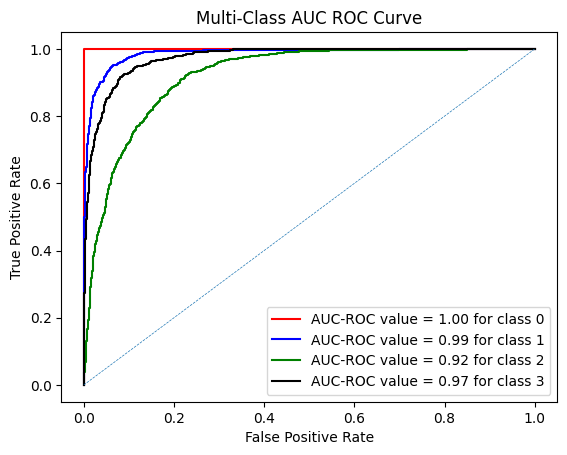

Confusion matrix - micro

 [[10364   526]
 [  531  3099]]
Classification report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       407
           1       0.91      0.90      0.91      1157
           2       0.78      0.79      0.79      1386
           3       0.82      0.81      0.81       680

   micro avg       0.85      0.85      0.85      3630
   macro avg       0.88      0.88      0.88      3630
weighted avg       0.86      0.85      0.85      3630
 samples avg       0.83      0.85      0.84      3630

Accuracy score

 0.8005509641873279


micro F1 Score : 0.8543073742246725


macro F1 Score : 0.8771429000938016


weight F1 Score : 0.8544006469772057


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [283]:
# Performance Evaluation

fpr = dict()
tpr = dict()
precision = dict()
recall = dict()
auc_roc = dict()
auc_pr = dict()

plt.figure(figsize=(8,6))

colors = ['red','blue','green','black']

for i,color in zip(n_classes, colors):
  recall[i], precision[i], _ = metrics.precision_recall_curve(y_test[:,i],model.predict_proba(x_test_sca)[:,i])
  auc_pr[i] = metrics.average_precision_score(y_test[:,i],model.predict_proba(x_test_sca)[:,i])
  plt.plot(recall[i], precision[i], color=color, label=f'AUC-PR value = {auc_pr[i]:.2f} for class {i}')
plt.plot([0,1],[0.5,0.5], linestyle='--', lw=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class AUC PR Curve')
plt.legend(loc='lower left')
plt.show()


for i,color in zip(n_classes,colors):
  fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i],model.predict_proba(x_test_sca)[:,i])
  auc_roc[i] = metrics.roc_auc_score(y_test[:,i],model.predict_proba(x_test_sca)[:,i])
  plt.plot(fpr[i], tpr[i], color=color, label = f'AUC-ROC value = {auc_roc[i]:.2f} for class {i}')
plt.plot([0,1],[0,1], linestyle='--', lw=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class AUC ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Confusion matrix - micro\n\n",metrics.confusion_matrix(y_test.ravel(),predict_test.ravel()))
print("Classification report\n\n",metrics.classification_report(y_test,predict_test))
print("Accuracy score\n\n",metrics.accuracy_score(y_test,predict_test))
print("\n\nmicro F1 Score :",metrics.f1_score(y_test,predict_test,average='micro'))
print("\n\nmacro F1 Score :",metrics.f1_score(y_test,predict_test,average='macro'))
print("\n\nweight F1 Score :",metrics.f1_score(y_test,predict_test,average='weighted'))
